<a href="https://colab.research.google.com/github/Cherishings/Deep_Learning/blob/main/Lab_3%2C_Part_3%2C_Yolo_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3, Part 4 Object Detection and Recognition using YOLOv8

## 4.1 Introduction

In this part of the lab we will implement a pre-trained model of the one-stage detection recognition system YOLO-v8. This is one of the most successful detection-recognition systems.

An example of the YOLO output is given below.

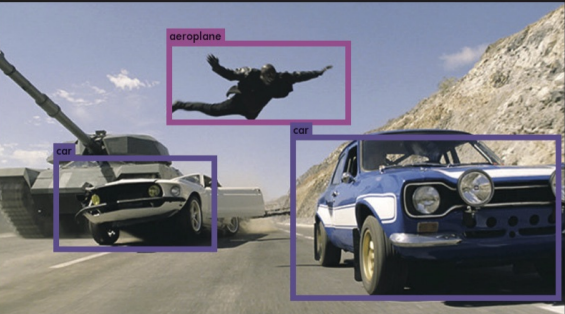

Yolo uses a deep convolutional network. The YOLO version 1 architecture is shown below (Redmon et al., 2016). This has evolved over the years but the formative ideas are still the same.


Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). You only look once: Unified, real-time object detection. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 779-788).

**YOLO-v1 architecture - a deep convolutional network**


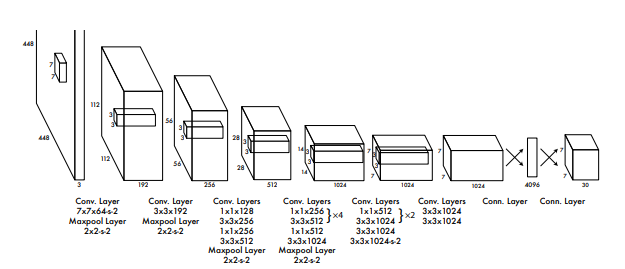

## 4.2 Install Keras CV (Computer Vision) to access a pre-trained YOLO model

It is typical to make use of a pre-trained model of an object detection-recognition system because they take so long to train, and either
* make direct use of the model, or
* re-train the model on some class specific data (known as transfer learning)

To use a pre-trained YOLO model in Keras, we will first install Keras_cv, which is an add-on for Keras, supported by the Keras team, that supports many tasks in computer vision, including:
* image data augmentation,
* image classification (recognition),
* object detection,
* semantic segmentation,
* image generation

Keras_cv includes many pre-trained models, which are useful in image processing where training classifiers and object detection/recognition systems takes a long time using large data sets.



In [ ]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

## 4.3 Load a test image

First, we need to load a test image to run YOLO-v8 on.

In [ ]:
# import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

# load a test image from a github folder
!wget -O test_image.jpg https://github.com/andrsn/data/blob/main/test_image.jpg?raw=true

# display the image
img_raw = cv2.imread("test_image.jpg")
img=cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# expand image dimension to include batch size, needed for YOLO predictions
img_batch = np.array(np.expand_dims(img, axis=0))



## 4.4 Load Pretrained Yolo-v8 from Keras CV

Notice that:

* You can set options for non-maximum suppression here, which can greatly alter the detection performance

* You can load the YOLO-v8 model with or without pre-trained weights, and the pre-trained weights can come from training on different data sets, e.g. Pascal VOC, COCO etc.

* Also note that the model summary is printed below after running the code block, and you can inspect this summary to check out what layers are included in YOLO-v8

In [ ]:
# import libraries
import tensorflow as tf
import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

# Set option for non-maximum suppression first, before loading the YOLO model
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format = "xywh", # define the bounding box format as x-y centre, width and height
    from_logits = True,           # true for logits, false for confidence
    iou_threshold = 0.5,          # IoU threshold: decrease the required threshold to make predictions get pruned out
    confidence_threshold = 0.2,   # Confidence threshold: all boxes below threshold are dicarded
)

# define the pretrained YOLO-v8 model, trained on the Pascal VOC dataset
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",                   # yolo-v8, with weights from training on Pascal VOC dataset
    num_classes = 20,                        # number of classes in the output head
    bounding_box_format = "xywh",            # bounding box format
    prediction_decoder = prediction_decoder, # options for non-maximum suppression
)

# print the model summary to inspect
model.summary()

## 4.5 Add some class mappings


In [ ]:
# define the 20 class labels from the pascal voc dataset

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

## 4.6 Predict and visualise

NOTE: the first time you do this lab the default setting for the confidence threshold in non-maximum suppression above, is

confidence_threshold = 0.2

Check out the result. It should not look too great (too many detections at low confidence). As part of the quiz you need to tune this threshold to prune out detections. But you can try tuning it now to see it's effect.

In [ ]:
# predict using Yolo-v8 pre-trained model on the test image loaded earlier
y_pred = model.predict(img_batch)

# visualise
visualization.plot_bounding_box_gallery(
    img_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=8,
    font_scale=0.7,
    show=True,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

## 4.7 How to re-train the Yolo model

This is how you would re-train the Yolo-v8 model given a dataset of images and target data consisting of boundings boxes and class labels. However, this takes a long time so we will not re-train here.

Notice the following though:
* The classification loss is based on binary cross-entropy as used in binary classification - this is NOT because YOLO-v8 is a binary classifier, but instead because it employs multi-label classification. The idea of multi-label classification is to assign an object potentially more than one class label - e.g. one particular car could have the mutiple labels: "Car", "Ferrari", "Sports Car". Therefore YOLO makes use of multiple binary classifiers to assign the possibility of each individual label.

* The other point to notice is that the bounding box regression loss is based on CIOU, which is a modern update of IoU (Intersection over Union) - CIOU is Complete IoU. The idea with this is that it is a more robust measure of bounding box accuracy, which takes into account both distance of the centre point prediction to the ground truth as well as the aspect ratio.






**Complete Intersection Over Union Metric - CIOU**

Figure from Gai, W., Liu, Y., Zhang, J., & Jing, G. (2021). An improved Tiny YOLOv3 for real-time object detection. Systems Science & Control Engineering, 9(1), 314-321.

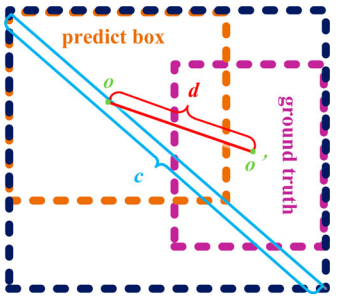

In [ ]:
# Compile the model
model.compile(
    classification_loss='binary_crossentropy',
    box_loss='ciou',
    optimizer=tf.optimizers.SGD(global_clipnorm=10.0),
    jit_compile=False,
)

# re-train the model using input images and output data labels
# NOTE: we have not defined input images and labels so we cannot do that here so
# this line below, model.fit, is commented out
# model.fit(images, labels)